In [7]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import copy

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline # Replaces sklearn Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# load the dataset and fix values

In [8]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


## split the dataset

In [9]:
X = dataset.drop(columns=["grade"])
y = dataset["grade"].map({"A": 6, "B": 5, "C": 4, "D": 3, "E": 2, "F": 1, "G": 0})

# 1. First Split: Separate out the final Hold-out Test set (e.g., 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# 2. Second Split: Separate Train from Validation (e.g., 10% of total, or 12.5% of the temp data)
# This ensures Validation data is never seen by the "fit" method
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp
)
# Resulting Ratios roughly: Train (70%), Val (10%), Test (20%)

In [10]:
class NumericExtractor(BaseEstimator, TransformerMixin):
    """Extracts integers from strings using regex"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = X[col].astype(str).str.extract(r"(\d+)").astype(float)
        return X

class CyclicalDateEncoder(BaseEstimator, TransformerMixin):
    """Converts mm-yyyy to year + sine/cosine month encoding."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            # errors="coerce" turns unparseable data/NaNs into NaT
            date_series = pd.to_datetime(X[col], format="%b-%Y", errors="coerce")
            # If date is NaT, these become NaN, which we handle in the pipeline later
            angle = 2 * np.pi * date_series.dt.month / 12

            X[f"{col}_year"] = date_series.dt.year
            X[f"{col}_month_sin"] = np.sin(angle)
            X[f"{col}_month_cos"] = np.cos(angle)
            
            X.drop(columns=[col], inplace=True)
        return X
    
class BinaryModeEncoder(BaseEstimator, TransformerMixin):
    """"Encodes 0 if value is mode, 1 if not"""
    def __init__(self):
        self.modes_ = {}

    def fit(self, X, y=None):
        # Calculate mode for each column and store it
        for col in X.columns:
            self.modes_[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mode in self.modes_.items():
            # Apply: 1 if NOT the mode (least frequent), 0 if mode
            X_copy[col] = (X_copy[col] != mode).astype(int)
        return X_copy
    
class HighMissingDropper(BaseEstimator, TransformerMixin):
    """Drops columns with high missing percentage. Fits only on training data."""
    
    def __init__(self, threshold=20):
        self.threshold = threshold
        self.cols_to_drop_ = []

    def fit(self, X, y=None):
        missing_percentages = X.isna().mean() * 100
        self.cols_to_drop_ = missing_percentages[missing_percentages > self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.cols_to_drop_)

In [ ]:
redundant_cols = ["loan_title", "borrower_address_state"]
binary_cols = ["loan_payment_plan_flag", "listing_initial_status", "application_type_label",
               "hardship_flag_indicator", "disbursement_method_type", "debt_settlement_flag_indicator"]
one_hot_encoding_cols = ["borrower_housing_ownership_status", "borrower_income_verification_status",
                       "loan_status_current_code", "loan_purpose_category"]
extract_fields = ["loan_contract_term_months", "borrower_profile_employment_length"]
date_fields = ["loan_issue_date", "credit_history_earliest_line", "last_payment_date", "last_credit_pull_date"]
embed_column = ["borrower_address_zip"]

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight

numeric_pipe = SkPipeline([
    ('extract', NumericExtractor()),
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = SkPipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

date_pipe = SkPipeline([
    ('cyclical', CyclicalDateEncoder()),
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # scaling is needed for the year, not for sin/cos
])

binary_pipe = SkPipeline([
    ('binary_enc', BinaryModeEncoder()), 
    ('impute', SimpleImputer(strategy='most_frequent'))
])

# remainder columns are numerical
remainder_pipe = SkPipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num_pipe', numeric_pipe, extract_fields),
    ('cat_pipe', categorical_pipe, one_hot_encoding_cols),
    ('date_pipe', date_pipe, date_fields),
    ('bin_pipe', binary_pipe, binary_cols),
    ('drop_redundant', 'drop', redundant_cols),
    ],
    remainder=remainder_pipe
)

numerical_pipeline = SkPipeline([
    ('dropper', HighMissingDropper(threshold=20)),
    ('prep', preprocessor),
])

zip_pipeline = SkPipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1))
])

numerical_columns = [c for c in X_train.columns if c not in embed_column]
print(numerical_columns)

X_numerical_train = numerical_pipeline.fit_transform(X_train[numerical_columns], y_train)
X_zip_train = zip_pipeline.fit_transform(X_train[embed_column]).squeeze()

X_numerical_val = numerical_pipeline.transform(X_val[numerical_columns])
X_zip_val = zip_pipeline.transform(X_val[embed_column]).squeeze()

X_numerical_test = numerical_pipeline.transform(X_test[numerical_columns])
X_zip_test = zip_pipeline.transform(X_test[embed_column]).squeeze()

print(X_numerical_train.shape)
print(X_zip_train.shape)
print(y_train.shape)

with open("ff_numerical_preprocessor.save", "wb") as f:
    pickle.dump(numerical_pipeline, f)
with open("ff_zip_preprocessor.save", "wb") as f:
    pickle.dump(zip_pipeline, f)

['loan_contract_approved_amount', 'loan_portfolio_total_funded', 'investor_side_funded_amount', 'loan_contract_term_months', 'loan_contract_interest_rate', 'loan_payment_installments_count', 'borrower_profile_employment_length', 'borrower_housing_ownership_status', 'borrower_income_annual', 'borrower_income_verification_status', 'loan_issue_date', 'loan_status_current_code', 'loan_payment_plan_flag', 'loan_purpose_category', 'loan_title', 'borrower_address_state', 'borrower_dti_ratio', 'credit_delinquencies_2yrs', 'credit_history_earliest_line', 'fico_score_low_bound', 'fico_score_high_bound', 'credit_inquiries_6m', 'months_since_last_delinquency', 'months_since_last_public_record', 'credit_open_accounts', 'credit_public_records', 'revolving_balance', 'revolving_utilization', 'credit_total_accounts', 'listing_initial_status', 'outstanding_principal_balance', 'outstanding_principal_investor_side', 'total_payment_received', 'total_payment_investor_side', 'total_received_principal', 'tota

/Users/geko/unibo/data_analytics/project/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/Users/geko/unibo/data_analytics/project/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [34]:
class FeedForwardModel(nn.Module):
    def __init__(self, cont_dim, hidden_dims=[128, 64, 32], output_dim=7):
        super().__init__()
        zip_embed_dim = 64
        num_zip_codes = 883 # borrower_address_zip 882 different values + 1 missing
        self.emb = nn.Embedding(num_zip_codes, zip_embed_dim)
        
        self.input_dim = cont_dim + zip_embed_dim

        layers = []
        in_dim = self.input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(0.2))
            in_dim = h_dim
        
        self.mlp = nn.Sequential(*layers)
        
        # Projects the last hidden layer to the number of classes (7)
        self.head = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X_cont, X_zip):
        # Embed zip codes
        # Result shape: (Batch_Size, zip_embed_dim)
        zip_embedded = self.emb(X_zip)
        
        # Concatenate continuous features + embeddings
        # Result shape: (Batch_Size, cont_dim + zip_embed_dim)
        x = torch.cat([X_cont, zip_embedded], dim=1)
        
        # Pass through MLP features
        x = self.mlp(x)
        
        # Final classification
        return self.head(x)

In [35]:
def create_dataset(X_num, X_zip, y):
    # Numerical features: Float32
    x_num_t = torch.tensor(X_num, dtype=torch.float32)
    
    # Zip indices: Long (Int64). 
    # Shift by +1 so -1 (unknown) becomes 0.
    x_zip_t = torch.tensor(X_zip, dtype=torch.long) + 1
    
    # Targets: Long for loss calculation
    y_t = torch.tensor(y.values, dtype=torch.long)
    
    return TensorDataset(x_num_t, x_zip_t, y_t)


BATCH_SIZE = 1024
EPOCHS = 200
LEARNING_RATE = 1e-3

input_cont_dim = X_numerical_train.shape[1]
hidden_dims = [128, 64, 32]

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

train_ds = create_dataset(X_numerical_train, X_zip_train, y_train)
val_ds = create_dataset(X_numerical_val, X_zip_val, y_val)
test_ds = create_dataset(X_numerical_test, X_zip_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = FeedForwardModel(cont_dim=input_cont_dim, hidden_dims=hidden_dims).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# Scheduler monitors 'min' because we want to minimize loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-6)

history = {
    'epoch': [],
    'train_loss': [], 'train_acc': [], 'train_bacc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_bacc': [], 'val_f1': [],
    'lr': []
}

best_val_loss = float('inf')
print("Starting training...")
for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for b_cont, b_zip, b_y in train_loader:
        b_cont, b_zip, b_y = b_cont.to(device), b_zip.to(device), b_y.to(device)
        
        optimizer.zero_grad()
        logits = model(b_cont, b_zip)
        loss = criterion(logits, b_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Collect for metrics (detach to save memory)
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(b_y.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    
    # Calculate Train Metrics
    t_acc = accuracy_score(train_targets, train_preds)
    t_bacc = balanced_accuracy_score(train_targets, train_preds)
    t_f1 = f1_score(train_targets, train_preds, average='weighted')

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for b_cont, b_zip, b_y in val_loader:
            b_cont, b_zip, b_y = b_cont.to(device), b_zip.to(device), b_y.to(device)
            logits = model(b_cont, b_zip)
            val_loss += criterion(logits, b_y).item()
            
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(b_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    
    # Calculate Val Metrics
    v_acc = accuracy_score(val_targets, val_preds)
    v_bacc = balanced_accuracy_score(val_targets, val_preds)
    v_f1 = f1_score(val_targets, val_preds, average='weighted')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_ff_model_weights.pth')
        print(f"Best model saved at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

    # Update Scheduler
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Logging
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(t_acc)
    history['train_bacc'].append(t_bacc)
    history['train_f1'].append(t_f1)
    
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(v_acc)
    history['val_bacc'].append(v_bacc)
    history['val_f1'].append(v_f1)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} | "
          f"Train BalAcc: {t_bacc:.4f} Val Bacc: {v_bacc:.4f} | "
          f"Train F1: {t_f1:.4f} Val F1: {v_f1:.4f} | LR: {current_lr:.1e}")

# Save Metrics to CSV
df_history = pd.DataFrame(history)
df_history.to_csv('training_metrics.csv', index=False)
print("\nMetrics saved to 'training_metrics.csv'")

Starting training...
Best model saved at epoch 1 with Val Loss: 1.1381
Epoch 1/200 | Train Loss: 1.5194 Val Loss: 1.1381 | Train BalAcc: 0.3591 Val Bacc: 0.5257 | Train F1: 0.3399 Val F1: 0.5267 | LR: 1.0e-03
Best model saved at epoch 2 with Val Loss: 0.7314
Epoch 2/200 | Train Loss: 0.9745 Val Loss: 0.7314 | Train BalAcc: 0.5941 Val Bacc: 0.7052 | Train F1: 0.6360 Val F1: 0.7520 | LR: 1.0e-03
Best model saved at epoch 3 with Val Loss: 0.5810
Epoch 3/200 | Train Loss: 0.7457 Val Loss: 0.5810 | Train BalAcc: 0.6809 Val Bacc: 0.7771 | Train F1: 0.7329 Val F1: 0.8163 | LR: 1.0e-03
Best model saved at epoch 4 with Val Loss: 0.5247
Epoch 4/200 | Train Loss: 0.6670 Val Loss: 0.5247 | Train BalAcc: 0.7151 Val Bacc: 0.8012 | Train F1: 0.7676 Val F1: 0.8387 | LR: 1.0e-03
Best model saved at epoch 5 with Val Loss: 0.4964
Epoch 5/200 | Train Loss: 0.6245 Val Loss: 0.4964 | Train BalAcc: 0.7380 Val Bacc: 0.8020 | Train F1: 0.7880 Val F1: 0.8472 | LR: 1.0e-03
Best model saved at epoch 6 with Val Lo

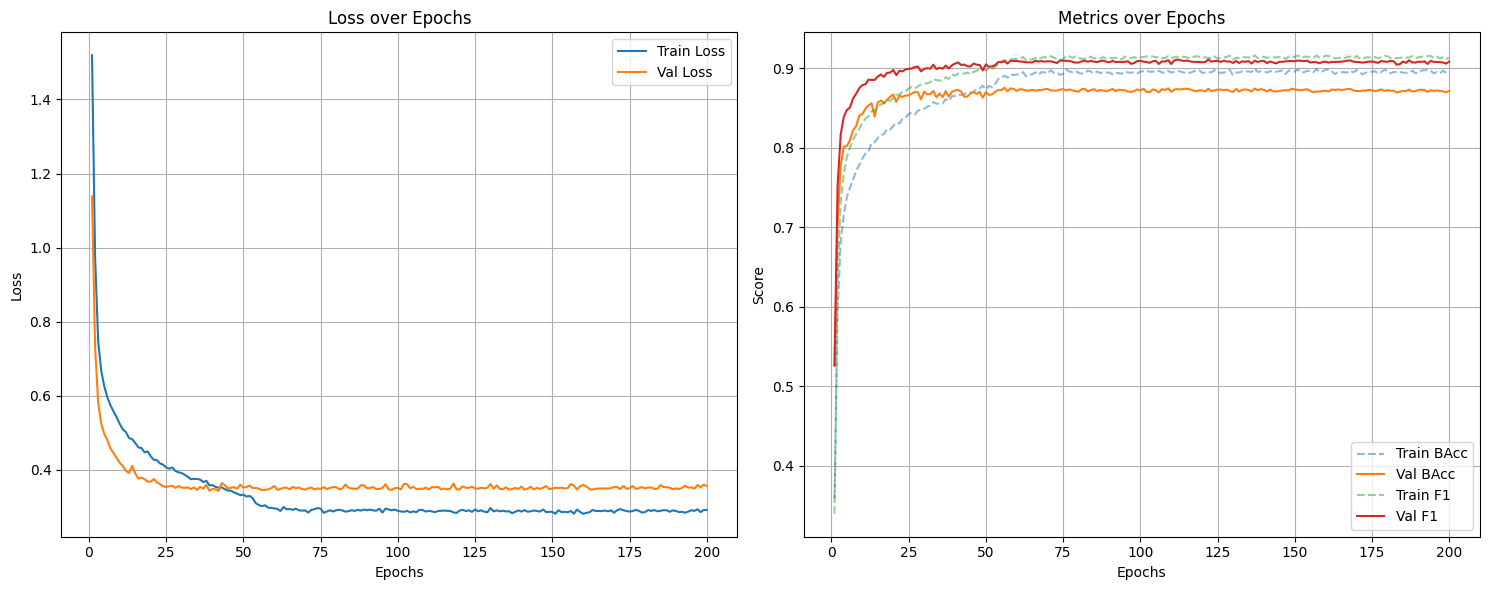

In [36]:
# Plotting
epochs_range = df_history['epoch']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Loss
ax1.plot(epochs_range, df_history['train_loss'], label='Train Loss')
ax1.plot(epochs_range, df_history['val_loss'], label='Val Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Balanced Accuracy
ax2.plot(epochs_range, df_history['train_bacc'], label='Train BAcc', linestyle='--', alpha=0.5)
ax2.plot(epochs_range, df_history['val_bacc'], label='Val BAcc')
ax2.plot(epochs_range, df_history['train_f1'], label='Train F1', linestyle='--', alpha=0.5)
ax2.plot(epochs_range, df_history['val_f1'], label='Val F1')
ax2.set_title('Metrics over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_plots.png')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

print("\nRunning final evaluation on Test Set...")
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for b_cont, b_zip, b_y in test_loader:
        # Move data to device
        b_cont, b_zip, b_y = b_cont.to(device), b_zip.to(device), b_y.to(device)
        
        # Forward pass
        logits = model(b_cont, b_zip)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Store results
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(b_y.cpu().numpy())

# Calculate Metrics
t_acc = accuracy_score(test_targets, test_preds)
t_bacc = balanced_accuracy_score(test_targets, test_preds)
t_f1 = f1_score(test_targets, test_preds, average='weighted')
conf_mat = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds)

# Print Results
print("-" * 30)
print(f"Test Set Accuracy:      {t_acc:.4f}")
print(f"Test Set Balanced Acc:  {t_bacc:.4f}")
print(f"Test Set Weighted F1:   {t_f1:.4f}")
print("-" * 30)
print("\nConfusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", class_report)


Running final evaluation on Test Set...
------------------------------
Test Set Accuracy:      0.9102
Test Set Balanced Acc:  0.8739
Test Set Weighted F1:   0.9100
------------------------------

Confusion Matrix:
 [[1026  177   13    1    0    0    0]
 [ 292 1050  156    4    3    0    0]
 [   8  153 2049  198    9    0    0]
 [   0    1  248 3829  166    4    3]
 [   1    0    3  205 6904  301    2]
 [   0    1    0    2  220 6966  359]
 [   0    0    0    0   25  110 5172]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.81      1217
           1       0.76      0.70      0.73      1505
           2       0.83      0.85      0.84      2417
           3       0.90      0.90      0.90      4251
           4       0.94      0.93      0.94      7416
           5       0.94      0.92      0.93      7548
           6       0.93      0.97      0.95      5307

    accuracy                           0.91     29661
   m

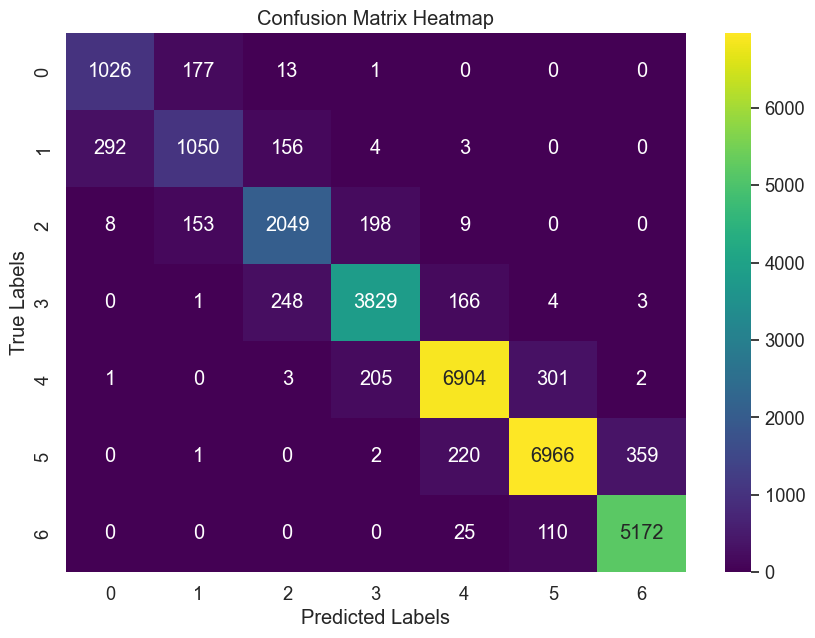

In [42]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2) # Adjust font size
    
    # annot=True adds the numbers, fmt='d' ensures they are integers
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Usage:
# Replace ['Class 0', 'Class 1'] with your actual category names
plot_confusion_matrix(conf_mat, class_names=['Class 0', 'Class 1'])